# Forecasting android app company privacy permissions requests
Michael Steckler, Chelsea Shu, Julian Pelzner, and Ollie Downs 

## Introduction
With the rise of new regulations, such as GDPR, privacy compliance organizations will need to forecast their future workflows. In order to complete and review permissions requests for mobile applications worldwide, privacy compliance organizations will need to hire compliance analysts, which affects their labor expenditures. We want to help these organizations with these forecasting tasks. We decided to focus on android apps in particular.

For some background context, the EU's General Data Protection Regulation (GDPR, implemented 2018) was a major privacy law that was aimed at regulating companies in ways that would protect people’s personal data, and curb some of the behavior of companies that has made the headlines of international news. The spirit of the legislation is rooted in the philosophy that people ought to have the right to control their own data assets. The fallout/aftermath of numerous scandals involving household technology companies, such as Cambridge Analytica, Facebook, the increasing awareness of targeted advertising, as well as the growing occurence of ransomware attacks has been sobering for the citizenry and lawmakers alike. 

With the rise of overarching privacy regulations, such as GDPR, privacy compliance organizations and lawmaking bodies will need to forecast their future workflows. In order to complete and review permissions requests for mobile applications worldwide, these organizations will need to adapt to increased workflows by hiring more compliance analysts. Considering that this could be costly and time-intensive for many organizations, the opportunity to solve vital, time-consuming problems is rich. As such, we have ventured to build privacy management tools and models to help organizations forecast, expedite, and make strategic decisions regarding privacy compliance. Our project could not be more relevant.

Our report focuses on building models related to permissions requests. In a theorized, ideal free market, the private sector and everyday people would come to an equilibrium in terms of the amount and appropriateness of permissions requests. The reality is that most individuals don’t have the time, capacity, or knowledge to understand the content and technical jargon within an app’s Terms and Conditions when they are downloaded onto people’s devices. Moreover, companies have not been fully transparent about how exactly they intend to use the personal data they gather. With GDPR, governments are now responding to this issue with more enhanced scrutiny on how companies can use data collected by permissions requests, especially permissions requests that are regarded as dangerous.

In this report, we compare several machine learning models to address two main business goals: <br> 
* Predicting the number of permissions requests by app, post-GDPR, 
* Predicting the number of dangerous permissions requests post-GDPR


Predicting the number of post-GDPR permissions requests can enable organizations to forecast the amount of requests their firms will need to process and how long it will take. Moreover, it is important to predict the number of both total and dangerous permissions requests because it can provide insights on how developers are asking for more permissions that needed to operate their apps. This information could be useful to inform future policy. 

In [70]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import urllib.request as urllib2 # For python3
import re

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

import tensorflow
import keras
from tensorflow.python.keras.layers import Input, Dense
from keras.models import Sequential

# Data
Our models are trained on data used in an Indiana University School of Informatics, Computing, and Engineering research paper titled “Apps, Code, Culture, and Market Reform: Examining Influences on Android Permissions” (2019). We credit the authors and contributors of this work for graciously allowing us to access this easily workable dataset. This dataset focuses on android apps in particular.

The original paper is included in this GitHub repository.

# Data Cleaning
* First, we imported and merged our two datasets.
* Then, we removed irrelevant columns.
* Then, we add indicator variables for each app's country.
* Then, we add indicator variables for each app's category.
* Then, we used regular expression and iteration to parse the raw text data. This enabled us to dummy code a variable for whether an app has requested permissions that were identified as dangerous in the research paper. We used this code to further count the number of dangerous permissions that were requested.

### Import and merge our two datasets

In [2]:
#import data
pre = pd.read_csv("OLD_permissions_data.csv")
post = pd.read_csv("NEW_permissions_data.csv")

#merge data
gdpr_merge = pre.merge(post, on = ['package_name', 'country'], how = 'inner',  suffixes=('_pre', '_post'))


gdpr_merge.head()

,record_num_pre,category_country_num_pre,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,record_num_post,category_country_num_post,category_post,google_rank_post,permissions_post,permission_count_post,file_size_post
0,1,1,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,1,1,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",2,3710134
1,3,3,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,2,2,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",27,5779024
2,5,5,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,3,3,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",21,17946632
3,7,7,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,4,4,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",22,12309718
4,8,8,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,5,5,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486213


### Remove irrelevant columns and check for holes in the dataset

In [3]:
#drop record num and category country number columns
gdpr_merge.drop(["record_num_pre","category_country_num_pre", "record_num_post", "category_country_num_post"],axis = 1, inplace = True)

In [4]:
#dropping rows that have no permissions
lst = list(gdpr_merge[gdpr_merge.permissions_pre == '[]'].index)
gdpr_merge.drop(lst, axis = 0, inplace = True)

In [5]:
#check for null values
gdpr_merge.isnull().sum()


gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,permission_count_post,file_size_post
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",2,3710134
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",27,5779024
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",21,17946632
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",22,12309718
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486213


### Adding columns to represent which country the app is from

In [6]:
#dummy code for country

US= []
SK= []
G= []
for i in gdpr_merge['country']:
    if i == 'United States':
        US.append(1)
        SK.append(0)
        G.append(0)
        
    elif i == "South Korea":
        US.append(0)
        SK.append(1)
        G.append(0)
    else:
        US.append(0)
        SK.append(0)
        G.append(1)

In [7]:
#add the 3 new columns into the dataframe and view the dataframe again
gdpr_merge['US'] = US
gdpr_merge['South Korea'] = SK
gdpr_merge['Germany'] = G


gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,permission_count_post,file_size_post,US,South Korea,Germany
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",2,3710134,1,0,0
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",27,5779024,1,0,0
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",21,17946632,1,0,0
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",22,12309718,1,0,0
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486213,1,0,0


### Adding columns to represent which category the app is in

In [8]:
#see how many unique categories there are
gdpr_merge['category_pre'].unique()

array(['Lifestyle', 'Social', 'Ages 5 & Under'], dtype=object)

In [9]:
#dummy code for category

l= []
a= []
s= []
for i in gdpr_merge['category_pre']:
    if i == 'Lifestyle':
        l.append(1)
        a.append(0)
        s.append(0)
        
    elif i == "Ages 5 & Under":
        a.append(1)
        l.append(0)
        s.append(0)
    else:
        s.append(1)
        a.append(0)
        l.append(0)
        
        
lp= []
ap= []
sp= []
for i in gdpr_merge['category_post']:
    if i == 'Lifestyle':
        lp.append(1)
        ap.append(0)
        sp.append(0)
        
    elif i == "Ages 5 & Under":
        ap.append(1)
        lp.append(0)
        sp.append(0)
    else:
        sp.append(1)
        ap.append(0)
        lp.append(0)

In [10]:
#add the new columns into the dataframe
gdpr_merge['Lifestyle_pre'] = l
gdpr_merge['Ages 5 and Under_pre'] = a
gdpr_merge['Social_pre'] = s

gdpr_merge['Lifestyle_post'] = lp
gdpr_merge['Ages 5 and Under_post'] = ap
gdpr_merge['Social_post'] = sp


gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,file_size_post,US,South Korea,Germany,Lifestyle_pre,Ages 5 and Under_pre,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,3710134,1,0,0,1,0,0,1,0,0
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,5779024,1,0,0,1,0,0,1,0,0
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,17946632,1,0,0,1,0,0,1,0,0
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,12309718,1,0,0,1,0,0,1,0,0
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,4486213,1,0,0,1,0,0,1,0,0


### Adding indicator and count columns for dangerous permissions

In [11]:
#first, we parse the data
##splitting the permission information into discrete objects
##and removing extraneous quotation marks
## (permission list in raw form was one string)
all_permissions_pre = gdpr_merge['permissions_pre']
lst = []
for i in all_permissions_pre:
    a = i.split("\"")
    for j in a:
        lst.append(j)
gdpr_merge["pre_parsed"] = lst

all_permissions_post = gdpr_merge['permissions_post']
lst2 = []
for i in all_permissions_post:
    a = i.split("\"")
    for j in a:
        lst2.append(j)
gdpr_merge["post_parsed"] = lst2


gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,South Korea,Germany,Lifestyle_pre,Ages 5 and Under_pre,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post,pre_parsed,post_parsed
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,0,0,1,0,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi..."
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,0,0,1,0,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi..."
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,0,0,1,0,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi..."
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,0,0,1,0,0,1,0,0,"['android.permission.GET_ACCOUNTS', 'android.p...","['android.permission.GET_ACCOUNTS', 'android.p..."
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,0,0,1,0,0,1,0,0,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '..."


In [12]:
##hard code list of dangerous permissions directly from the paper
dangerous = ["READ_CALENDAR", "WRITE_CALENDAR", "READ_CALL_LOG", 
             "WRITE_CALL_LOG", "PROCESS_OUTGOING_CALLS", "CAMERA",
             "READ_CONTACTS", "WRITE_CONTACTS", "GET_ACCOUNTS", 
             "ACCESS_FINE_LOCATION", "ACCESS_COURSE_LOCATION", 
             "RECORD_AUDIO", "READ_PHONE_STATE", "READ_PHONE_NUMBERS", 
             "CALL_PHONE", "ANSWER_PHONE_CALLS", "ADD_VOICEMAIL", 
             "USE_SIP", "BODY_SENSORS", "SEND_SMS", "RECEIVE_SMS", 
             "READ_SMS", "RECEIVE_WAP_PUSH", "RECEIVE_MMS", 
             "READ_EXTERNAL_STORAGE","WRITE_EXTERNAL_STORAGE"]

dang = []
safe = []
for row in gdpr_merge["pre_parsed"]:
    perms = re.findall("[A-Z]\w+", row)
    dangs = []
    safes = []   
    for perm in perms: 
        if perm in dangerous:
            dangs.append(1)
            safes.append(0)
        else:
            dangs.append(0)
            safes.append(1)
    dang.append(dangs)
    safe.append(safes)

gdpr_merge["pre_parsed_dangerous"] = dang
gdpr_merge["pre_parsed_safe"] = safe

dang2 = []
safe2 = []
for row in gdpr_merge["post_parsed"]:
    perms = re.findall("[A-Z]\w+", row)
    dangs = []
    safes = []   
    for perm in perms: 
        if perm in dangerous:
            dangs.append(1)
            safes.append(0)
        else:
            dangs.append(0)
            safes.append(1)
    dang2.append(dangs)
    safe2.append(safes)
gdpr_merge["post_parsed_dangerous"] = dang2
gdpr_merge["post_parsed_safe"] = safe2


gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post,pre_parsed,post_parsed,pre_parsed_dangerous,pre_parsed_safe,post_parsed_dangerous,post_parsed_safe
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0]","[1, 1]","[0, 0]","[1, 1]"
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ..."
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,0,1,0,0,"['android.permission.GET_ACCOUNTS', 'android.p...","['android.permission.GET_ACCOUNTS', 'android.p...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ..."
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,0,1,0,0,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '...","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]"


In [13]:
#dummy coding for whether an app has pre and post dangerous permissions
dangerous_pre= []
dangerous_post= []

for i in gdpr_merge["pre_parsed_dangerous"]:
    if sum(i) > 0:
        dangerous_pre.append(1)
         
    else:
        dangerous_pre.append(0)
        
for i in gdpr_merge["post_parsed_dangerous"]:
    if sum(i) > 0:
        dangerous_post.append(1)
         
    else:
        dangerous_post.append(0)

gdpr_merge['pre_dangerous'] = dangerous_pre
gdpr_merge['post_dangerous'] = dangerous_post

gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,Ages 5 and Under_post,Social_post,pre_parsed,post_parsed,pre_parsed_dangerous,pre_parsed_safe,post_parsed_dangerous,post_parsed_safe,pre_dangerous,post_dangerous
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0]","[1, 1]","[0, 0]","[1, 1]",0,0
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...",1,1
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,0,0,"['android.permission.GET_ACCOUNTS', 'android.p...","['android.permission.GET_ACCOUNTS', 'android.p...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...",1,1
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,0,0,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '...","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]",1,1


In [14]:
## dummy coding for pre and post dangerous permissions counts
dangerous_pre_count= []
dangerous_post_count= []

for i in gdpr_merge["pre_parsed_dangerous"]:
    dangerous_pre_count.append(sum(i))
         
        
for i in gdpr_merge["post_parsed_dangerous"]:
    dangerous_post_count.append(sum(i))
         

gdpr_merge['pre_dangerous_count'] = dangerous_pre_count
gdpr_merge['post_dangerous_count'] = dangerous_post_count


gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,pre_parsed,post_parsed,pre_parsed_dangerous,pre_parsed_safe,post_parsed_dangerous,post_parsed_safe,pre_dangerous,post_dangerous,pre_dangerous_count,post_dangerous_count
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0]","[1, 1]","[0, 0]","[1, 1]",0,0,0,0
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1,4,3
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...",1,1,6,6
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,"['android.permission.GET_ACCOUNTS', 'android.p...","['android.permission.GET_ACCOUNTS', 'android.p...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...",1,1,6,6
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '...","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]",1,1,2,2


# EDA

## PERMISSION COUNTS

In [50]:
gdpr_merge.describe().permission_count_post

count    2790.000000
mean       14.488889
std        16.571965
min         1.000000
25%         7.000000
50%        11.000000
75%        18.000000
max       436.000000
Name: permission_count_post, dtype: float64

In [51]:
gdpr_merge.describe().permission_count_pre

count    2790.000000
mean       13.566308
std        15.668894
min         1.000000
25%         6.000000
50%        10.000000
75%        17.000000
max       436.000000
Name: permission_count_pre, dtype: float64

In [52]:
#here we produce a new dataframe that removes the pre-permission count outlier (436)
no_outlier = gdpr_merge[gdpr_merge['permission_count_pre'] < 200]
no_outlier = no_outlier[no_outlier['permission_count_post'] < 200]


no_outlier.describe().permission_count_pre

count    2788.000000
mean       13.263271
std        10.841566
min         1.000000
25%         6.000000
50%        10.000000
75%        17.000000
max       127.000000
Name: permission_count_pre, dtype: float64

### Distribution of Permission Counts by Category

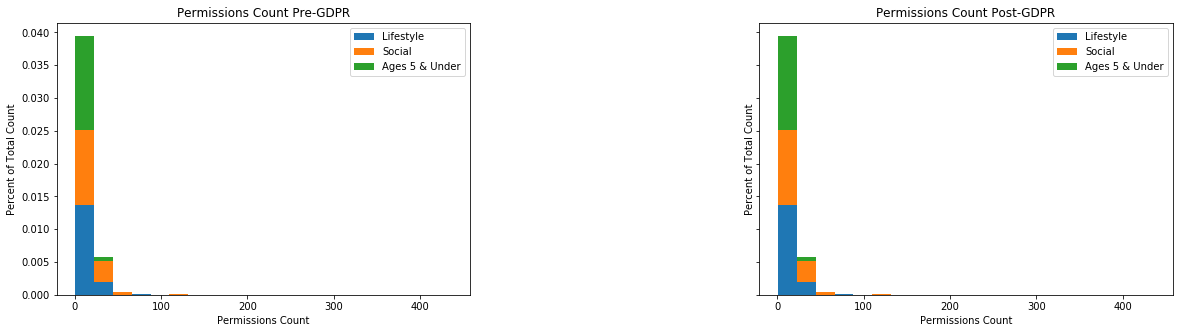

In [17]:
countries = ["US", "South Korea", "Germany"]
categories = ["Lifestyle", "Social", "Ages 5 & Under"]
prerank = gdpr_merge['permission_count_pre']
postrank = gdpr_merge['permission_count_post']
li_pre = prerank.where(gdpr_merge["category_pre"] == "Lifestyle")
so_pre = prerank.where(gdpr_merge["category_pre"] == "Social")
ag_pre = prerank.where(gdpr_merge["category_pre"] == "Ages 5 & Under")
li_post = postrank.where(gdpr_merge["category_post"] == "Lifestyle")
so_post = postrank.where(gdpr_merge["category_post"] == "Social")
ag_post = postrank.where(gdpr_merge["category_post"] == "Ages 5 & Under")
fig, axs = plt.subplots(1,2, figsize = (20,5), sharey = True)
axs = axs.flatten()
axs[0].hist([li_pre, so_pre, ag_pre], bins=20, stacked=True, normed = True)
axs[0].set_xlabel('Permissions Count')
axs[0].set_ylabel('Percent of Total Count')
axs[0].set_title('Permissions Count Pre-GDPR')
axs[0].legend(["Lifestyle", "Social", "Ages 5 & Under"])
axs[1].hist([li_pre, so_pre, ag_pre], bins=20, stacked=True, normed = True)
axs[1].set_xlabel('Permissions Count')
axs[1].set_ylabel('Percent of Total Count')
axs[1].set_title('Permissions Count Post-GDPR')
axs[1].legend(["Lifestyle", "Social", "Ages 5 & Under"])
plt.subplots_adjust(wspace = 0.7, hspace = 0.7)

### Distribution of Permission Counts by Category (Without Outlier)

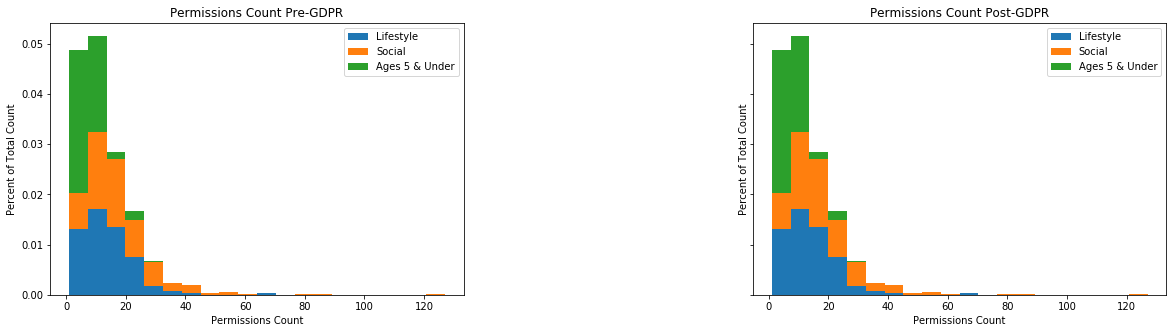

In [18]:
countries = ["US", "South Korea", "Germany"]
categories = ["Lifestyle", "Social", "Ages 5 & Under"]
prerank = no_outlier['permission_count_pre']
postrank = no_outlier['permission_count_post']
li_pre = prerank.where(no_outlier["category_pre"] == "Lifestyle")
so_pre = prerank.where(no_outlier["category_pre"] == "Social")
ag_pre = prerank.where(no_outlier["category_pre"] == "Ages 5 & Under")
li_post = postrank.where(no_outlier["category_post"] == "Lifestyle")
so_post = postrank.where(no_outlier["category_post"] == "Social")
ag_post = postrank.where(no_outlier["category_post"] == "Ages 5 & Under")
fig, axs = plt.subplots(1,2, figsize = (20,5), sharey = True)
axs = axs.flatten()
axs[0].hist([li_pre, so_pre, ag_pre], bins=20, stacked=True, normed = True)
axs[0].set_xlabel('Permissions Count')
axs[0].set_ylabel('Percent of Total Count')
axs[0].set_title('Permissions Count Pre-GDPR')
axs[0].legend(["Lifestyle", "Social", "Ages 5 & Under"])
axs[1].hist([li_pre, so_pre, ag_pre], bins=20, stacked=True, normed = True)
axs[1].set_xlabel('Permissions Count')
axs[1].set_ylabel('Percent of Total Count')
axs[1].set_title('Permissions Count Post-GDPR')
axs[1].legend(["Lifestyle", "Social", "Ages 5 & Under"])
plt.subplots_adjust(wspace = 0.7, hspace = 0.7)

NOTE: <br>
Here, we are just producing a graphic without the outlier to have a clearer view of the distribution. <br>
We still need to explore the outlier to determine whether or not we will omit this datapoint.

### Distribution of Direction of Change in Permission Counts After GDPR

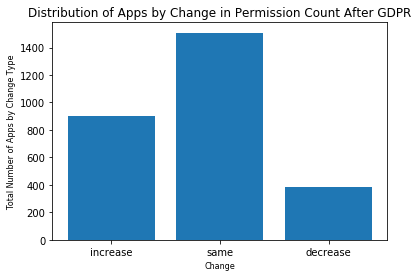

In [19]:
increase_count = gdpr_merge[gdpr_merge['permission_count_post'] > gdpr_merge['permission_count_pre']].shape[0]
same_count = gdpr_merge[gdpr_merge['permission_count_post'] == gdpr_merge['permission_count_pre']].shape[0]
decrease_count = gdpr_merge[gdpr_merge['permission_count_post'] < gdpr_merge['permission_count_pre']].shape[0]

permission_change_counts = [increase_count, same_count, decrease_count]

change_types = ['increase', 'same', 'decrease']
plt.bar(np.arange(len(change_types)), permission_change_counts)
plt.xlabel('Change', fontsize=8)
plt.ylabel('Total Number of Apps by Change Type', fontsize=8)
plt.xticks(np.arange(len(change_types)),change_types, fontsize=10)
plt.title('Distribution of Apps by Change in Permission Count After GDPR')
plt.show()

## DANGEROUS PERMISSIONS

In [20]:
gdpr_merge.describe().pre_dangerous_count

count    2790.000000
mean        3.344444
std         3.011034
min         0.000000
25%         1.000000
50%         2.500000
75%         5.000000
max        23.000000
Name: pre_dangerous_count, dtype: float64

In [21]:
gdpr_merge.describe().post_dangerous_count

count    2790.000000
mean        3.391756
std         3.151761
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        23.000000
Name: post_dangerous_count, dtype: float64

### Distribution of Dangerous Permissions by App, Pre and Post GDPR

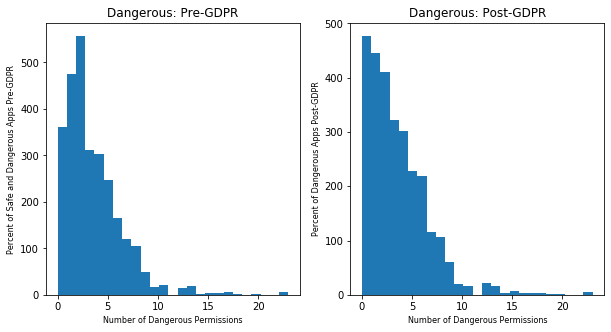

<Figure size 432x288 with 0 Axes>

In [22]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs = axs.flatten()
app_safety_type = ['safe','dangerous']
pre = gdpr_merge['pre_dangerous_count']
post = gdpr_merge['post_dangerous_count']
axs[0].hist(pre, bins=25)
axs[0].set_xlabel('Number of Dangerous Permissions', fontsize=8)
axs[0].set_ylabel('Percent of Safe and Dangerous Apps Pre-GDPR', fontsize=8)
axs[0].set_title('Dangerous: Pre-GDPR')
axs[1].hist(post, bins=25)
axs[1].set_xlabel('Number of Dangerous Permissions', fontsize=8)
axs[1].set_ylabel('Percent of Dangerous Apps Post-GDPR', fontsize=8)
axs[1].set_title('Dangerous: Post-GDPR')
plt.show()
plt.subplots_adjust(wspace = 0.7, hspace = 0.7)

### Distribution of Dangerous Permission Counts by Category

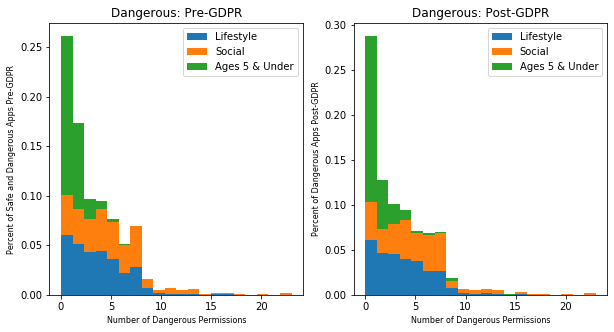

<Figure size 432x288 with 0 Axes>

In [23]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs = axs.flatten()
app_safety_type = ['safe','dangerous']
pre = gdpr_merge['pre_dangerous_count']
post = gdpr_merge['post_dangerous_count']
l_pre = pre.where(gdpr_merge["category_pre"] == "Lifestyle")
s_pre = pre.where(gdpr_merge["category_pre"] == "Social")
a_pre = pre.where(gdpr_merge["category_pre"] == "Ages 5 & Under")
l_post = post.where(gdpr_merge["category_post"] == "Lifestyle")
s_post = post.where(gdpr_merge["category_post"] == "Social")
a_post = post.where(gdpr_merge["category_post"] == "Ages 5 & Under")
axs[0].hist([l_pre, s_pre, a_pre], bins=20, stacked=True, normed = True)
axs[0].set_xlabel('Number of Dangerous Permissions', fontsize=8)
axs[0].set_ylabel('Percent of Safe and Dangerous Apps Pre-GDPR', fontsize=8)
axs[0].set_title('Dangerous: Pre-GDPR')
axs[0].legend(["Lifestyle", "Social", "Ages 5 & Under"])
axs[1].hist([l_post, s_post, a_post], bins=20, stacked=True, normed = True)
axs[1].set_xlabel('Number of Dangerous Permissions', fontsize=8)
axs[1].set_ylabel('Percent of Dangerous Apps Post-GDPR', fontsize=8)
axs[1].set_title('Dangerous: Post-GDPR')
axs[1].legend(["Lifestyle", "Social", "Ages 5 & Under"])
plt.show()
plt.subplots_adjust(wspace = 0.7, hspace = 0.7)

### Distribution of Direction of Change in Dangerous Permission Counts After GDPR

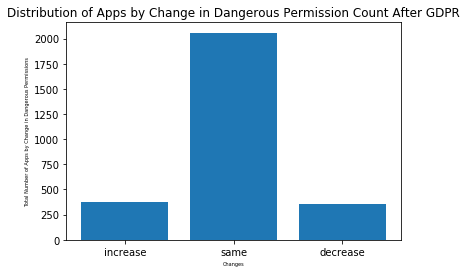

In [24]:
increase_dangerous_count = gdpr_merge[gdpr_merge['post_dangerous_count'] > gdpr_merge['pre_dangerous_count']].shape[0]
same_dangerous_count = gdpr_merge[gdpr_merge['post_dangerous_count'] == gdpr_merge['pre_dangerous_count']].shape[0]
decrease_dangerous_count = gdpr_merge[gdpr_merge['post_dangerous_count'] < gdpr_merge['pre_dangerous_count']].shape[0]

dangerous_permission_change_counts = [increase_dangerous_count, same_dangerous_count, decrease_dangerous_count]

change_types = ['increase', 'same', 'decrease']
plt.bar(np.arange(len(change_types)), dangerous_permission_change_counts)
plt.xlabel('Changes', fontsize=5)
plt.ylabel('Total Number of Apps by Change in Dangerous Permissions', fontsize=5)
plt.xticks(np.arange(len(change_types)),change_types, fontsize=10)
plt.title('Distribution of Apps by Change in Dangerous Permission Count After GDPR')
plt.show()

### Distribution of Safe and Dangerous Permission Counts, Pre and Post GDPR

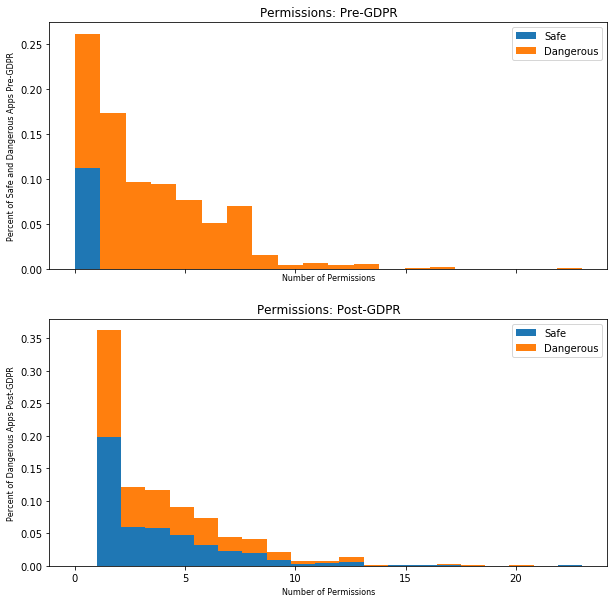

<Figure size 432x288 with 0 Axes>

In [25]:
fig, axs = plt.subplots(2,1, figsize = (10,10), sharex = True)
axs = axs.flatten()
app_safety_type = ['safe','dangerous']
pre = gdpr_merge['pre_dangerous_count']
post = gdpr_merge['post_dangerous_count']
pre_safe = pre.where(gdpr_merge["pre_dangerous"] == 0)
post_safe = post.where(gdpr_merge["post_dangerous"] == 0)
pre_dang = pre.where(gdpr_merge["pre_dangerous"] != 0)
post_dang = post.where(gdpr_merge["post_dangerous"] != 0)
axs[0].hist([pre_safe, pre_dang], bins=20, stacked=True, normed = True)
axs[0].set_xlabel('Number of Permissions', fontsize=8)
axs[0].set_ylabel('Percent of Safe and Dangerous Apps Pre-GDPR', fontsize=8)
axs[0].set_title('Permissions: Pre-GDPR')
axs[0].legend(["Safe", "Dangerous"])
axs[1].hist([pre_dang, post_dang], bins=20, stacked=True, normed = True)
axs[1].set_xlabel('Number of Permissions', fontsize=8)
axs[1].set_ylabel('Percent of Dangerous Apps Post-GDPR', fontsize=8)
axs[1].set_title('Permissions: Post-GDPR')
axs[1].legend(["Safe", "Dangerous"])
plt.show()
plt.subplots_adjust(wspace = 0.7, hspace = 0.7)

### Distribution of Apps by Whether They Contain Dangerous Permissions, Pre and Post GDPR

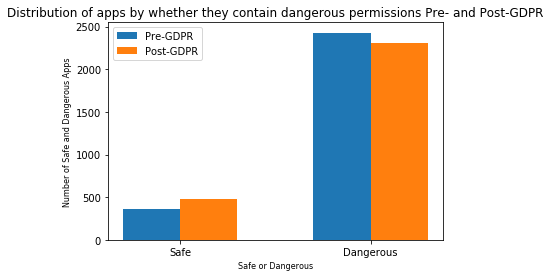

In [26]:
safe_apps_count_pre = 0
dangerous_apps_count_pre = 0
for i in gdpr_merge['pre_dangerous']:
    if i==0:
        safe_apps_count_pre += 1
    if i==1:
        dangerous_apps_count_pre += 1
safe_apps_count_post = 0
dangerous_apps_count_post = 0
for i in gdpr_merge['post_dangerous']:
    if i==0:
        safe_apps_count_post += 1
    if i==1:
        dangerous_apps_count_post += 1
app_safety_count_pre = [safe_apps_count_pre, dangerous_apps_count_pre]
app_safety_count_post = [safe_apps_count_post, dangerous_apps_count_post]
app_safety_type = ['Safe','Dangerous']
# plt.bar(ind, men_means, width, label='Men')
# plt.bar(ind + width, women_means, width,
#     label='Women')
width = 0.3
plt.bar(np.arange(len(app_safety_type)), app_safety_count_pre, width, label = "Pre-GDPR")
plt.bar(np.arange(len(app_safety_type))+width, app_safety_count_post, width, label = "Post-GDPR")
plt.xlabel('Safe or Dangerous', fontsize=8)
plt.ylabel('Number of Safe and Dangerous Apps', fontsize=8)
plt.xticks(np.arange(len(app_safety_type)) + (width/2), app_safety_type, fontsize=10)
plt.title('Distribution of apps by whether they contain dangerous permissions Pre- and Post-GDPR')
plt.legend()
plt.show()

In [27]:
#big correlation matrix
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = gdpr_merge.corr()
corr.style.background_gradient(cmap='coolwarm')

,google_rank_pre,permission_count_pre,file_size_pre,google_rank_post,permission_count_post,file_size_post,US,South Korea,Germany,Lifestyle_pre,Ages 5 and Under_pre,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post,pre_dangerous,post_dangerous,pre_dangerous_count,post_dangerous_count
google_rank_pre,1,-0.0862589,-0.0986919,0.712442,-0.086163,-0.100245,-0.0165188,-0.0175505,0.0342766,-0.00263349,-0.0074493,0.0100343,-0.00249784,-0.0074493,0.0098912,-0.12515,-0.0899297,-0.140262,-0.134403
permission_count_pre,-0.0862589,1,-0.0515508,-0.103153,0.958279,-0.0380619,0.00843744,0.0617485,-0.0710132,0.0081659,-0.26726,0.256663,0.00726044,-0.26726,0.257441,0.202489,0.210213,0.670339,0.642624
file_size_pre,-0.0986919,-0.0515508,1,-0.102692,-0.0610716,0.964147,0.0521563,-0.0770746,0.0260746,-0.218065,0.446035,-0.222535,-0.217726,0.446035,-0.222867,0.0408204,-0.00991788,-0.0942901,-0.0954375
google_rank_post,0.712442,-0.103153,-0.102692,1,-0.104435,-0.10121,-0.00944972,-0.00913508,0.018691,-0.0540237,0.0390804,0.0156545,-0.0524133,0.0390804,0.0139995,-0.0991909,-0.0296659,-0.152152,-0.135736
permission_count_post,-0.086163,0.958279,-0.0610716,-0.104435,1,-0.0298732,0.00868389,0.0533772,-0.0627735,0.014471,-0.274923,0.25791,0.0140214,-0.274923,0.258232,0.179994,0.237259,0.656483,0.675955
file_size_post,-0.100245,-0.0380619,0.964147,-0.10121,-0.0298732,1,0.0535236,-0.0749613,0.022568,-0.222417,0.430398,-0.202657,-0.222653,0.430398,-0.202422,0.0455717,0.0127532,-0.0687604,-0.0533852
US,-0.0165188,0.00843744,0.0521563,-0.00944972,0.00868389,0.0535236,1,-0.505886,-0.485225,-0.0125326,0.0116134,0.00110684,-0.0147134,0.0116134,0.00329317,0.00867855,0.0350275,0.00285724,0.0015258
South Korea,-0.0175505,0.0617485,-0.0770746,-0.00913508,0.0533772,-0.0749613,-0.505886,1,-0.50878,0.0189739,-0.025675,0.00634509,0.0184965,-0.025675,0.00683137,0.0660481,0.00265235,0.125071,0.117395
Germany,0.0342766,-0.0710132,0.0260746,0.018691,-0.0627735,0.022568,-0.485225,-0.50878,1,-0.00672534,0.0144354,-0.00753646,-0.00406489,0.0144354,-0.0102114,-0.0756122,-0.0376469,-0.129632,-0.120523
Lifestyle_pre,-0.00263349,0.0081659,-0.218065,-0.0540237,0.014471,-0.222417,-0.0125326,0.0189739,-0.00672534,1,-0.499011,-0.512159,0.99682,-0.499011,-0.508186,0.092774,0.147942,0.0912735,0.091432


# Predicting post-GDPR permission counts

The goal of our first set of models is to predict the number of permissions requests after GDPR. <br>
Because our outcome variable is continuous, we will use linear regression as our predictive linear regression model.

In [28]:
#train-test splitting the data

y = gdpr_merge['permission_count_post']
train_data, X, train_labels, Y = train_test_split(gdpr_merge[['permission_count_pre']], y, test_size=0.4, random_state = 2)
print ("Train_data: " + str(train_data.shape))
print ("Train_labels: " + str(train_labels.shape))
length = int(len(X)/2)
dev_data = X[0:length]
dev_labels = Y[0:length]
test_data = X[length:]
test_labels = Y[length:]
print ("Dev data: " + str(dev_data.shape))
print ("Dev_labels: " + str(dev_labels.shape))
print ("Test_data: " + str(test_data.shape))
print ("Test_labels: " + str(test_labels.shape))

Train_data: (1674, 1)
Train_labels: (1674,)
Dev data: (558, 1)
Dev_labels: (558,)
Test_data: (558, 1)
Test_labels: (558,)


Then we printed correlations between the amount of permission counts post-GDPR and all of the variables that we have information on pre-GDPR.

In [29]:
#printing correlations between label variable (permission count post) and all of the other pre-GDPR variables

new = gdpr_merge[['permission_count_post','permission_count_pre',
                  'category_pre', 'google_rank_pre','permissions_pre', 'file_size_pre',
                  'US', 'South Korea','Germany', 'Lifestyle_pre', 
                  'Ages 5 and Under_pre', 'Social_pre']]
corr = new.corr()
abs(corr['permission_count_post']).sort_values()
(corr['permission_count_post']).sort_values()

Ages 5 and Under_pre    -0.274923
google_rank_pre         -0.086163
Germany                 -0.062773
file_size_pre           -0.061072
US                       0.008684
Lifestyle_pre            0.014471
South Korea              0.053377
Social_pre               0.257910
permission_count_pre     0.958279
permission_count_post    1.000000
Name: permission_count_post, dtype: float64

Permission counts pre-GDPR have the highest correletion with post-GDPR permission counts at 95.8% accuracy, so we will start by creating a bivariate model between those two variables.

Based on the high correlation between `permission_count_pre` and `permission_count_post`, we decide to do a scatterplot between the two variables to assess the shape of the relationship.

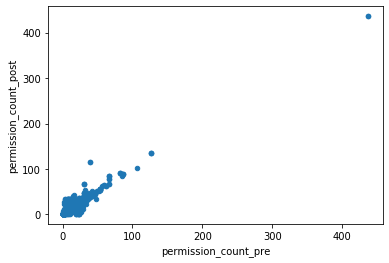

In [30]:
gdpr_merge.plot(x='permission_count_pre', y='permission_count_post', kind = 'scatter')

While the relationship between variables displayed in this diagnostic plot appears to be linear, we choose to run another scatterplot, this time omitting the outlier so that we can get a closer look at the main cluster of data.

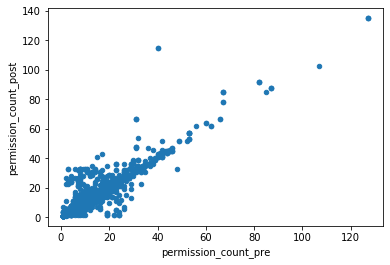

In [31]:
no_outlier.plot(x='permission_count_pre', y='permission_count_post', kind = 'scatter')

This second scatterplot provides evidence to support our initial hypothesis that the most appropriate relationship between the variables is a linear relationship.

Looking back at the first scatter plot, we see that there is an extreme outlier with over 400 permissions requested both pre and post GDPR. However, referencing our earlier EDA, we know that a majority of datapoints have a 1:1 relationship between pre-GDPR permission count and post-GDPR permission count. And therefore, because we are assuming a linear relationship, this point does not appear to have an undue influence on our model, and so we choose to keep it.

### Bivariate Model: Predicting post-GDPR permission counts from pre-GDPR permission counts

In [32]:
lin_model = LinearRegression()
lin_model.fit(train_data, train_labels)
predicted_accuracy = lin_model.predict(dev_data)
r2= lin_model.score(dev_data, dev_labels)  
print ("The R^2 of the regression model is " + str(r2))

The R^2 of the regression model is 0.7972541972709944


Our bivariate model gives us a pretty decent $R^2$ ! <br>
Let's see if adding any other variables will help make our model even better. <br>
We will start with using the next variable, `social_pre`, an indicator for the 'Social' category, which has the next highest correlation with post-GDPR permission counts.

### Multivariate Model: Adding in the Pre-GDPR Social Category Indicator variable

In [33]:
#resplit the train and test data to add more variables

y = gdpr_merge['permission_count_post']
train_data, X, train_labels, Y = train_test_split(gdpr_merge[['permission_count_pre','Social_pre']], 
                                                             y, test_size=0.4, random_state = 2)
print ("Train_data: " + str(train_data.shape))
print ("Train_labels: " + str(train_labels.shape))
length = int(len(X)/2)
dev_data = X[0:length]
dev_labels = Y[0:length]
test_data = X[length:]
test_labels = Y[length:]
print ("Dev data: " + str(dev_data.shape))
print ("Dev_labels: " + str(dev_labels.shape))
print ("Test_data: " + str(test_data.shape))
print ("Test_labels: " + str(test_labels.shape))

Train_data: (1674, 2)
Train_labels: (1674,)
Dev data: (558, 2)
Dev_labels: (558,)
Test_data: (558, 2)
Test_labels: (558,)


In [34]:
lin_model = LinearRegression()
lin_model.fit(train_data, train_labels)
predicted_accuracy = lin_model.predict(dev_data)
r2= lin_model.score(dev_data, dev_labels)  
print ("The R^2 of the regression model is " + str(r2))

The R^2 of the regression model is 0.7975250068870754


As we can see, our model's accuracy did not increase with the inclusion of `social_pre`, although that variable has a moderate correlation with `permission_count_post`. If we continued to add more variables into our model, those variables will not add much accuracy to our model either, because they only have 5% or lower correlation with post-GDPR permission counts.  Additionally, adding more variables for the sake of increasing accuracy can result in overfitting the model to the test data, especially when each additional variable increases the accuracy by very little. 

To prevent overfitting, we believe that our bivariate model is the best model to predict post-GDPR permission counts.
Let's see if we can explore other approaches to improving our model accuracy, such as cross-validation.

### Bivariate Model with Cross-Validation

In [35]:
features = gdpr_merge[['permission_count_pre']]

#resplit the train and test data
y = gdpr_merge['permission_count_post']
train_data, test_data, train_labels, test_labels = train_test_split(features, y, test_size=0.3, random_state = 1)
lin_model = LinearRegression()
scores = cross_val_score(lin_model, train_data, train_labels, cv = 5) 
predictions = cross_val_predict(lin_model, test_data, test_labels, cv = 5)  
accuracy = metrics.r2_score(test_labels, predictions) 
print ("Accuracy from the best cross-validation fold: ", accuracy)
lin_model.fit(train_data, train_labels)
predicted_accuracy = lin_model.predict(test_data)
r2= lin_model.score(test_data, test_labels)  
print ("The R^2 of the regression model is " + str(r2))

Accuracy from the best cross-validation fold:  0.8814490858273734
The R^2 of the regression model is 0.879935265692064


Our cross-validation actually shows an increase in our $R^2$. Not only does this increase our $R^2$ score, but it is estimating closer to the true $R^2$ score. It could be that our train and test subset that we originally chose had a less linear structure, but the cross-validation shows the more accurate $R^2$ because it tests over all subsets of our data.

## Alternate Models

### K-Neighbors

In [36]:
#resplit the train and test data to add more variables

y = gdpr_merge['permission_count_post']
train_data, X, train_labels, Y = train_test_split(gdpr_merge[['permission_count_pre','Social_pre']], 
                                                             y, test_size=0.4, random_state = 3)
print ("Train_data: " + str(train_data.shape))
print ("Train_labels: " + str(train_labels.shape))
length = int(len(X)/2)
dev_data = X[0:length]
dev_labels = Y[0:length]
test_data = X[length:]
test_labels = Y[length:]
print ("Dev data: " + str(dev_data.shape))
print ("Dev_labels: " + str(dev_labels.shape))
print ("Test_data: " + str(test_data.shape))
print ("Test_labels: " + str(test_labels.shape))

Train_data: (1674, 2)
Train_labels: (1674,)
Dev data: (558, 2)
Dev_labels: (558,)
Test_data: (558, 2)
Test_labels: (558,)


The optimal value for k is 13 with a f1_score of 0.4902681146031176


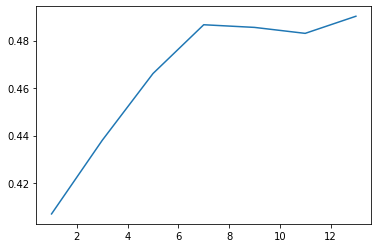

In [37]:
k_list = [1,3,5,7,9,11,13]
f1_scores = []
for k in k_list:
    KNN_model = KNeighborsClassifier(n_neighbors = k)
    KNN_model.fit(train_data,train_labels)
    KNN_labels = KNN_model.predict(dev_data)
    f1_scores.append(metrics.f1_score(dev_labels,KNN_labels, average = 'weighted'))
index = f1_scores.index(max(f1_scores))
max_f1 = max(f1_scores)
print ("The optimal value for k is " + str(k_list[index]) + " with a f1_score of " + str(max_f1))

plt.plot(k_list, f1_scores)

# Predicting *dangerous* post-GDPR permission counts

In [38]:
#split the train and test data

y = gdpr_merge['post_dangerous_count']
train_data, X, train_labels, Y = train_test_split(gdpr_merge[['pre_dangerous_count']], y, test_size=0.4, random_state = 1)
print ("Train_data: " + str(train_data.shape))
print ("Train_labels: " + str(train_labels.shape))
length = int(len(X)/2)
dev_data = X[0:length]
dev_labels = Y[0:length]
test_data = X[length:]
test_labels = Y[length:]
print ("Dev data: " + str(dev_data.shape))
print ("Dev_labels: " + str(dev_labels.shape))
print ("Test_data: " + str(test_data.shape))
print ("Test_labels: " + str(test_labels.shape))

Train_data: (1674, 1)
Train_labels: (1674,)
Dev data: (558, 1)
Dev_labels: (558,)
Test_data: (558, 1)
Test_labels: (558,)


In [39]:
df = gdpr_merge[['post_dangerous_count','permission_count_pre',
                   'google_rank_pre', 'file_size_pre',
                  'US', 'South Korea','Germany', 'Lifestyle_pre', 
                  'Ages 5 and Under_pre', 'Social_pre', 'pre_dangerous', 'pre_dangerous_count']]
corr = df.corr()
abs(corr['post_dangerous_count']).sort_values()

US                      0.001526
Lifestyle_pre           0.091432
file_size_pre           0.095438
South Korea             0.117395
Germany                 0.120523
google_rank_pre         0.134403
Social_pre              0.357603
pre_dangerous           0.362799
Ages 5 and Under_pre    0.453684
permission_count_pre    0.642624
pre_dangerous_count     0.927411
post_dangerous_count    1.000000
Name: post_dangerous_count, dtype: float64

*Dangerous* permission counts pre-GDPR have the highest correletion with *dangerous* post-GDPR permission counts at 92.7% accuracy, so we will start by creating a bivariate model between those two variables.

Based on the high correlation between `pre_dangerous_count` and `post_dangerous_count`, we decide to do a scatterplot between the two variables to assess the shape of the relationship.

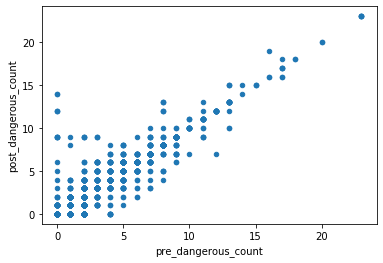

In [40]:
gdpr_merge.plot(x='pre_dangerous_count', y='post_dangerous_count', kind = 'scatter')

From the scatterplot above, we can deduce that the strongest type of relationship between the variables is a linear one. <br>
Therefore, we will begin to build our model as a bivariate linear regression.

### Bivariate Model: Predicting *dangerous* post-GDPR permission counts from *dangerous* pre-GDPR permission counts

In [41]:
lin_model = LinearRegression()
lin_model.fit(train_data, train_labels)
predicted_accuracy = lin_model.predict(dev_data)
r2= lin_model.score(dev_data, dev_labels)  
print ("The R^2 of the regression model is " + str(r2))

The R^2 of the regression model is 0.9051677005368548


This baseline model produces a pretty good $R^2$. <br>
Next, let's see if we can improve our accuracy by including additional regressors. <br>
We will start by adding the variable `permission_count_pre`, which has the next highest correlation with post-GDPR dangerous permission counts.

### Multivariate Model: Adding in the Pre-GDPR Permission Count variable

In [42]:
#split the train and test data

y = gdpr_merge['post_dangerous_count']
train_data, X, train_labels, Y = train_test_split(gdpr_merge[['pre_dangerous_count', 'permission_count_pre']], y, test_size=0.4, random_state = 1)
print ("Train_data: " + str(train_data.shape))
print ("Train_labels: " + str(train_labels.shape))
length = int(len(X)/2)
dev_data = X[0:length]
dev_labels = Y[0:length]
test_data = X[length:]
test_labels = Y[length:]
print ("Dev data: " + str(dev_data.shape))
print ("Dev_labels: " + str(dev_labels.shape))
print ("Test_data: " + str(test_data.shape))
print ("Test_labels: " + str(test_labels.shape))

Train_data: (1674, 2)
Train_labels: (1674,)
Dev data: (558, 2)
Dev_labels: (558,)
Test_data: (558, 2)
Test_labels: (558,)


In [43]:
lin_model = LinearRegression()
lin_model.fit(train_data, train_labels)
predicted_accuracy = lin_model.predict(dev_data)
r2= lin_model.score(dev_data, dev_labels)  
print ("The R^2 of the regression model is " + str(r2))

The R^2 of the regression model is 0.9047421834652236


Here, our model's accuracy decreases with the inclusion of `permission_count_pre`. Therefore, if we continued to add more regressors, our model's accuracy can be expected to stay the same or decrease because all the other independent variables have smaller correlations with our outcome variable. For this reason, we will proceed using our bivariate model.

Next, we will try to implement Cross-Validation to attempt to get a more precise estimate our model's true $R^2$.

### Bivariate Model with Cross-Validation

In [44]:
#from github
features = gdpr_merge[['pre_dangerous_count']]
#split the train and test data
y = gdpr_merge['post_dangerous_count']
train_data, test_data, train_labels, test_labels = train_test_split(features, y, test_size=0.3, random_state = 1)
print ("Train_data: " + str(train_data.shape))
print ("Train_labels: " + str(train_labels.shape))
print ("Test_data: " + str(test_data.shape))
print ("Test_labels: " + str(test_labels.shape))
lin_model = LinearRegression()
scores = cross_val_score(lin_model, train_data, train_labels, cv = 2) 
predictions = cross_val_predict(lin_model, test_data, test_labels, cv = 2)  
# print (predictions)
accuracy = metrics.r2_score(test_labels, predictions) 
print (accuracy)
lin_model.fit(train_data, train_labels)
predicted_accuracy = lin_model.predict(test_data)
r2= lin_model.score(test_data, test_labels)  
print ("The R^2 of the regression model is " + str(r2))

Train_data: (1953, 1)
Train_labels: (1953,)
Test_data: (837, 1)
Test_labels: (837,)
0.9052973915066564
The R^2 of the regression model is 0.904120438718886


While the $R^2$ of this bivariate model did not increase with Cross-Validation, this $R^2$ value is probably a more accurate estimate of the model's true $R^2$.

## Alternate Models

### Neural Network

In [58]:
features = gdpr_merge[['pre_dangerous_count']]

#split the train and test data
y = gdpr_merge['post_dangerous_count']
train_data, test_data, train_labels, test_labels = train_test_split(features, y, test_size=0.3, random_state = 1)
print ("Train_data: " + str(train_data.shape))
print ("Train_labels: " + str(train_labels.shape))
print ("Test_data: " + str(test_data.shape))
print ("Test_labels: " + str(test_labels.shape))

Train_data: (1953, 1)
Train_labels: (1953,)
Test_data: (837, 1)
Test_labels: (837,)


In [64]:
model = tensorflow.keras.Sequential()

#input layer
model.add(Dense(128, kernel_initializer='normal',input_dim = 1, activation='relu'))

#hidden layer
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

#output layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [65]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [66]:
model.fit(train_data, train_labels, epochs=5, batch_size=32, validation_split = 0.2)

Train on 1562 samples, validate on 391 samples
Epoch 1/5
1562/1562 [==============================] - 0s 201us/sample - loss: 1.2553 - mean_absolute_error: 1.2553 - val_loss: 0.5736 - val_mean_absolute_error: 0.5736
Epoch 2/5
1562/1562 [==============================] - 0s 108us/sample - loss: 0.5264 - mean_absolute_error: 0.5264 - val_loss: 0.5108 - val_mean_absolute_error: 0.5108
Epoch 3/5
1562/1562 [==============================] - 0s 144us/sample - loss: 0.5410 - mean_absolute_error: 0.5410 - val_loss: 0.4940 - val_mean_absolute_error: 0.4940
Epoch 4/5
1562/1562 [==============================] - 0s 96us/sample - loss: 0.5239 - mean_absolute_error: 0.5239 - val_loss: 0.5202 - val_mean_absolute_error: 0.5202
Epoch 5/5
1562/1562 [==============================] - 0s 101us/sample - loss: 0.5787 - mean_absolute_error: 0.5787 - val_loss: 0.5837 - val_mean_absolute_error: 0.5837


In [67]:
test_labels = np.asarray(test_labels, dtype = 'int64')
predicted_labels = model.predict(test_data)
predicted_labels

array([[ 4.8119192e+00],
       [ 5.7626090e+00],
       [ 6.7133055e+00],
       [ 2.9093156e+00],
       [-4.5151729e-04],
       [ 2.9093156e+00],
       [ 9.8625922e-01],
       [ 5.7626090e+00],
       [ 1.9520979e+00],
       [ 9.8625922e-01],
       [ 1.9520979e+00],
       [ 3.8612354e+00],
       [ 5.7626090e+00],
       [ 3.8612354e+00],
       [ 9.8625922e-01],
       [-4.5151729e-04],
       [ 3.8612354e+00],
       [ 3.8612354e+00],
       [-4.5151729e-04],
       [ 3.8612354e+00],
       [ 6.7133055e+00],
       [ 2.9093156e+00],
       [ 9.8625922e-01],
       [ 1.9520979e+00],
       [ 1.9520979e+00],
       [ 4.8119192e+00],
       [ 9.8625922e-01],
       [-4.5151729e-04],
       [ 1.9520979e+00],
       [ 1.2417469e+01],
       [ 9.8625922e-01],
       [ 6.7133055e+00],
       [ 9.8625922e-01],
       [ 3.8612354e+00],
       [ 1.9520979e+00],
       [ 1.9520979e+00],
       [ 2.9093156e+00],
       [-4.5151729e-04],
       [ 2.9093156e+00],
       [ 3.8612354e+00],


In [68]:
new_labels = []
for i in predicted_labels:
    new_labels.append(int(round(i[0])))

In [69]:
print ("The accuracy of the Neural Net is ", metrics.f1_score(test_labels, new_labels, average='weighted'))

The accuracy of the Neural Net is  0.7469714797919772
